In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

from tqdm import tqdm
import pickle
#import h5py
import time

import numpy as np
import healpy as hp
#import scipy.interpolate as interpolate
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import jax.numpy as jnp
#from jax import jit, vmap

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.units_constants import *
from utils.geometry import *
from utils.spectral import *
from utils.nfw import *
from utils.map_utils import *
from utils.snr import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

## config

In [9]:
freq_arr = np.linspace(400, 800, 100)[:3] # [MHz]
field_model = 'AH'
level = 2 # 0: naive gegenschein, 1: 3D modification, 2: with SNR
if level == 0:
    run_name = 'naive_gegenschein'
elif level == 1:
    run_name = f'field_{field_model}'
elif level == 2:
    run_name = f'field_{field_model}_snr'

verbose = 0 # 0: nothing, 1: info, 2: debug

SAVE_DIR = '../data/estimates'

## 1. run

In [15]:
import jax.profiler as profiler
os.environ['JAX_PROFILE_TF_DISABLE_PLATFORM_CHECK'] = '1'

In [16]:
## pre-loop
profiler.start_trace('../trace/profile')
tot_SNR_arr = np.zeros_like(freq_arr)

## loop
for i_freq, freq in enumerate(tqdm(freq_arr)):

    ## 1. Map grid
    CHIME_size_ra  = 80 * 100 # [cm]
    CHIME_size_dec = 100 * 100 # [cm]
    CHIME_ra_max = 2 * jnp.pi
    CHIME_ra_min = 0
    CHIME_dec_max = jnp.deg2rad(90)
    CHIME_dec_min = jnp.deg2rad(-20)
    CHIME_dec = jnp.deg2rad(49.3)
    CHIME_extent = (360, 0, -20, 90)

    def ra_pixel_size(ra): # [rad]
        return (c0 / freq) / CHIME_size_ra
    def dec_pixel_size(dec): # [rad]
        return (c0 / freq) / CHIME_size_dec * np.cos(dec - CHIME_dec)

    ra_edges  = jnp.linspace(CHIME_ra_min, CHIME_ra_max,
                             int((CHIME_ra_max-CHIME_ra_min)/ra_pixel_size(0)))
    dec_edges = jnp.array(
        grid_edges(dec_pixel_size, CHIME_dec_min, CHIME_dec_max, a_mid=CHIME_dec)
    )
    ra_s  = (ra_edges[:-1]  + ra_edges[1:] ) / 2
    dec_s = (dec_edges[:-1] + dec_edges[1:]) / 2
    ra_grid, dec_grid = jnp.meshgrid(ra_s, dec_s)
    radec_flat = jnp.stack([ra_grid.ravel(), dec_grid.ravel()], axis=-1)
    radec_shape = (len(dec_s), len(ra_s))

    coord_grid = SkyCoord(ra=ra_grid*u.rad, dec=dec_grid*u.rad, frame='icrs')
    l_grid = jnp.asarray(coord_grid.galactic.l.rad)
    b_grid = jnp.asarray(coord_grid.galactic.b.rad)
    lb_flat = jnp.stack([l_grid.ravel(), b_grid.ravel()], axis=-1)

    anti_l_grid = l_grid + jnp.pi
    anti_l_grid = jnp.where(anti_l_grid > 2*jnp.pi, anti_l_grid - 2*jnp.pi, anti_l_grid)
    anti_b_grid = - b_grid
    anti_lb_flat = jnp.stack([anti_l_grid.ravel(), anti_b_grid.ravel()], axis=-1)

    ## 2. Source (Haslam) map
    nu_haslam = 408 # [MHz]
    beta = -2.55
    haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
    haslam_dsds_map_hp *= (freq/nu_haslam) ** beta
    haslam_dsds_map = hp.pixelfunc.get_interp_val(
        haslam_dsds_map_hp, jnp.rad2deg(l_grid), jnp.rad2deg(b_grid), lonlat=True
    )

    ## 3. DM column integral
    rho_integral_map = rho_integral(lb_flat).reshape(radec_shape)

    ## 4. Naive gegenschein / reference forwardschein temperature
    haslam_anti_dsds_map = hp.pixelfunc.get_interp_val(
        haslam_dsds_map_hp, anti_l_grid/deg, anti_b_grid/deg, lonlat=True
    )
    gegen_temp_map = prefac(freq) * haslam_anti_dsds_map * rho_integral_map # naive gegenschein
    forward_temp_map = prefac(freq) * haslam_dsds_map * rho_integral_ref
    # reference forward+front temperature # I_src * 10kpc uniform column with rho_NFW(r_Sun)

    ## 5. Exposure
    t_baseline = 600 # [s]
    sec_in_day = 86400 # [s]
    CHIME_double_pass_dec = np.deg2rad(70)
    exposure_map = jnp.minimum(sec_in_day,
        (dec_grid > CHIME_dec_min) * ((dec_grid > CHIME_double_pass_dec) + 1) \
        * t_baseline / jnp.abs(jnp.cos(dec_grid))
    )

    ## 6. Naive S/N
    CHIME_n_day = 3.5 * 365 # [day] of observation
    CHIME_T_antenna = 50. # [K]
    T_sys_map = CHIME_T_antenna + haslam_dsds_map # [K]
    SNR_g_s = gegen_temp_map * jnp.sqrt(
        2 * dnu(freq) * 1e6 * exposure_map * CHIME_n_day
    ) / T_sys_map
    SNR_f_s = forward_temp_map * jnp.sqrt(
        2 * dnu(freq) * 1e6 * exposure_map * CHIME_n_day
    ) / T_sys_map
    
    if level == 0: # naive gegenschein
        tot_SNR_arr[i_freq] = np.sqrt(np.sum(SNR_g_s**2))
        continue
    
    ## 7. S/N with modification according to 3D model
    I_data = pickle.load(open(f'../data/galactic_models/I_data_{field_model}.dict', 'rb'))
    g_ratio_lr = I_data['focused'] / I_data['naive']
    f_ratio_lr = (I_data['front'] + I_data['forward']) / I_data['forward_ref']

    lb_flat_minuspi_to_pi = jnp.where(lb_flat > jnp.pi, lb_flat-2*jnp.pi, lb_flat)
    g_ratio = interpolate_padded(
        g_ratio_lr, I_data['l'], I_data['b'], lb_flat_minuspi_to_pi
    ).reshape(radec_shape)
    f_ratio = interpolate_padded(
        f_ratio_lr, I_data['l'], I_data['b'], lb_flat_minuspi_to_pi
    ).reshape(radec_shape)

    sig_temp_map = gegen_temp_map * g_ratio + forward_temp_map * f_ratio
    bkg_temp_map = haslam_dsds_map + CHIME_T_antenna
    
    if level == 1: # 3D modification
        SNR_map = (sig_temp_map / bkg_temp_map) * jnp.sqrt(
            2 * dnu(freq) * 1e6 * exposure_map * CHIME_n_day
        )
        tot_SNR_arr[i_freq] = jnp.sqrt(jnp.sum(SNR_map**2))
        continue
    
    ## 8. Add snr to map
    sig_temp_map_snr = np.array(sig_temp_map).copy()
    pixel_area_map = jnp.outer(
        (dec_edges[1:] - dec_edges[:-1]),
        (ra_edges[1:] - ra_edges[:-1])
    ) * jnp.cos(dec_s)[:,None] # [sr]
    snr_list = pickle.load(open('../data/SNR/snrlist.p', 'rb'))
    n_sigma = 3
    
    for snr in snr_list:
        snr_ra = snr.coord.icrs.ra.rad
        snr_dec = snr.coord.icrs.dec.rad
        snr_anti_ra  = snr_ra + jnp.pi if snr_ra < jnp.pi else snr_ra - jnp.pi
        snr_anti_dec = - snr_dec
        
        # gegenschein
        if snr_anti_dec < CHIME_dec_min: # not visible
            continue
        i_ra_st  = int(jnp.searchsorted(ra_s,  snr_anti_ra  - n_sigma*snr.image_sigma))
        i_ra_ed  = int(jnp.searchsorted(ra_s,  snr_anti_ra  + n_sigma*snr.image_sigma))
        i_dec_st = int(jnp.searchsorted(dec_s, snr_anti_dec - n_sigma*snr.image_sigma))
        i_dec_ed = int(jnp.searchsorted(dec_s, snr_anti_dec + n_sigma*snr.image_sigma))
        
        ra_subgrid, dec_subgrid = jnp.meshgrid(ra_s[i_ra_st:i_ra_ed], dec_s[i_dec_st:i_dec_ed])
        tmpl = gaussian_val(snr.image_sigma, snr_anti_ra, snr_anti_dec, ra_subgrid, dec_subgrid)
        pixel_area_submap = pixel_area_map[i_dec_st:i_dec_ed, i_ra_st:i_ra_ed]
        tmpl = np.array(tmpl) * pixel_area_submap
        tmpl /= np.sum(tmpl)

        T_submap = snr.Sgnu(freq)*Jy * tmpl * c0**2 / (2 * freq**2 * pixel_area_submap * kb)
        # [K] = [MHz^2 g] [cm MHz]^2 [MHz]^-2 [cm^2 MHz^2 g K^-1]^-1
        
        sig_temp_map_snr[i_dec_st:i_dec_ed, i_ra_st:i_ra_ed] += T_submap
    
    if level == 2: # snr
        SNR_map = (sig_temp_map_snr / bkg_temp_map) * jnp.sqrt(
            2 * dnu(freq) * 1e6 * exposure_map * CHIME_n_day
        )
        tot_SNR_arr[i_freq] = jnp.sqrt(jnp.sum(SNR_map**2))
        continue
    
    if verbose >= 1:
        print(f'freq = {freq:.3f} MHz, SNR = {tot_SNR:.6f}')
    
    if verbose >= 2:
        print('===== DEBUG =====')
        print('rho_integral_ref =', rho_integral_ref, '[g/cm^2]')
        print('naive gegenschein:', jnp.sqrt(jnp.sum(SNR_g_s**2)))
        print('reference forwardschein:', jnp.sqrt(jnp.sum(SNR_f_s**2)))
        print('=================')
        
profiler.stop_trace()

2023-03-21 00:05:00.248284: E external/org_tensorflow/tensorflow/compiler/xla/python/profiler/internal/python_hooks.cc:398] Can't import tensorflow.python.profiler.trace
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]
2023-03-21 00:05:05.665222: E external/org_tensorflow/tensorflow/compiler/xla/python/profiler/internal/python_hooks.cc:398] Can't import tensorflow.python.profiler.trace


KeyError: 'JAX_PROFILE_TF_DISABLE_PLATFORM_CHECK'

In [8]:
save_dict = {
    'freq' : freq_arr,
    'SNR'  : tot_SNR_arr,
}
fn = f'{SAVE_DIR}/{run_name}.p'
pickle.dump(save_dict, open(fn, 'wb'))

## WIP

### WIP.source

## 2. Intermediate plots

In [58]:
prefix = f'{SAVE_DIR}/plots_{run_name}'
os.makedirs(prefix, exist_ok=True)

Plot saved: ../data/estimates/plots_field_AH/pixel_grid.png


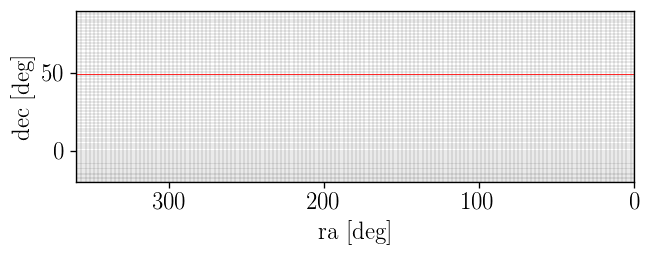

In [54]:
save_fn = f'{prefix}/pixel_grid.png'
fig, ax = plt.subplots()
for a in ra_edges[::10]:
    ax.axvline(np.rad2deg(a), color='k', lw=0.1)
for a in dec_edges[::10]:
    ax.axhline(np.rad2deg(a), color='k', lw=0.1)
ax.axhline(np.rad2deg(CHIME_dec), color='r', lw=0.5)
ax.set(xlim=CHIME_extent[:2], ylim=CHIME_extent[2:4], aspect=1)
ax.set(xlabel='ra [deg]', ylabel='dec [deg]')
plt.savefig(save_fn)
print(f'Plot saved: {save_fn}')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/haslam.png


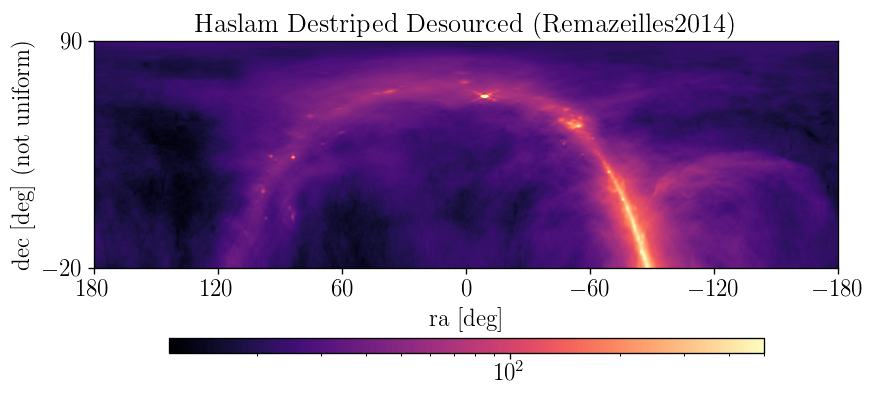

In [47]:
plot_radec(haslam_dsds_map, extent=CHIME_extent, vmax=500,
           title=r'Haslam Destriped Desourced (Remazeilles2014)', cmap='magma',
           save_fn=f'{prefix}/haslam.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/nfw.png


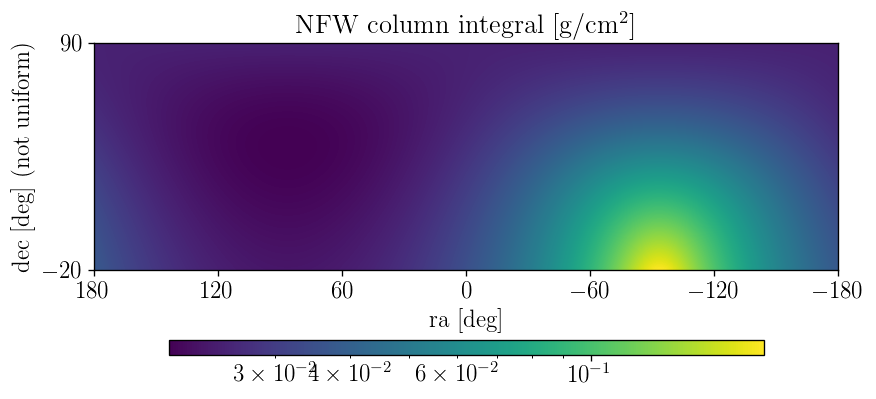

In [48]:
plot_radec(rho_integral_map, extent=CHIME_extent,
           title=r'NFW column integral [g/cm$^2$]', cmap='viridis',
           save_fn=f'{prefix}/nfw.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/naive_gegenschein.png


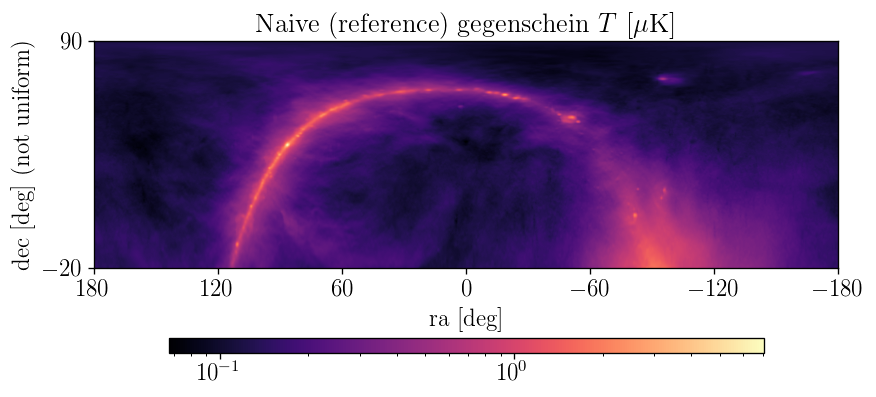

In [49]:
plot_radec(gegen_temp_map * 1e6, extent=CHIME_extent,
           title=r'Naive (reference) gegenschein $T$ [$\mu$K]', cmap='magma',
           save_fn=f'{prefix}/naive_gegenschein.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/reference_forwardschein.png


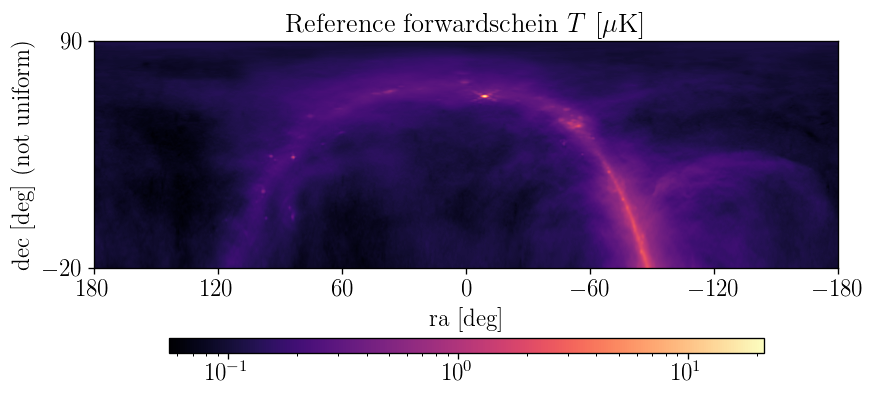

In [50]:
plot_radec(forward_temp_map * 1e6, extent=CHIME_extent,
           title=r'Reference forwardschein $T$ [$\mu$K]', cmap='magma',
           save_fn=f'{prefix}/reference_forwardschein.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/exposure.png


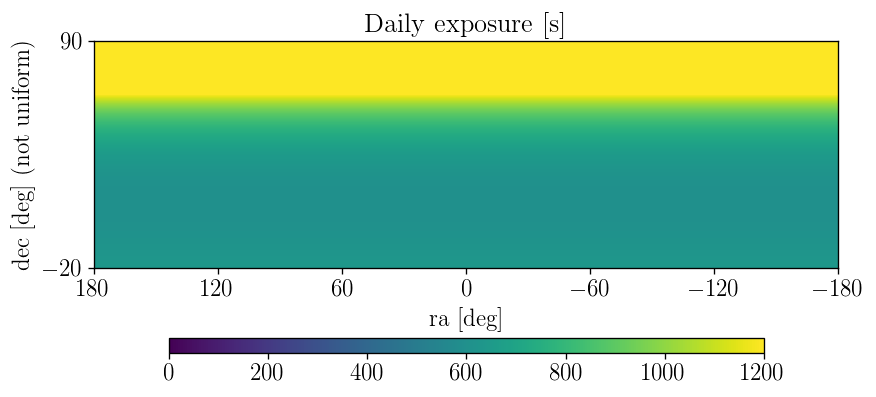

In [51]:
plot_radec(exposure_map, extent=CHIME_extent, log_norm=False,
           title='Daily exposure [s]', vmax=1200, vmin=0, cmap='viridis',
           save_fn=f'{prefix}/exposure.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/gegenschein_S_N.png


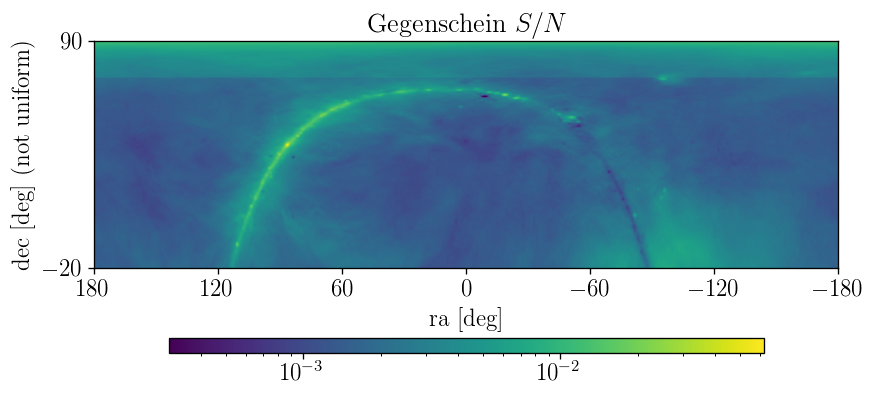

In [52]:
plot_radec(np.clip(SNR_g_s, 3e-4, None), extent=CHIME_extent,
           title=r'Gegenschein $S/N$', cmap='viridis',
           save_fn=f'{prefix}/gegenschein_S_N.png')

Plot saved: ../data/estimates/plots_field_AH/dependence_pixels.png
Contribution to S/N:
all pixels:  0.59312904
pixels > 1e-2:  0.033539753
pixels 1e-3 ~ 1e-2:  0.44730407


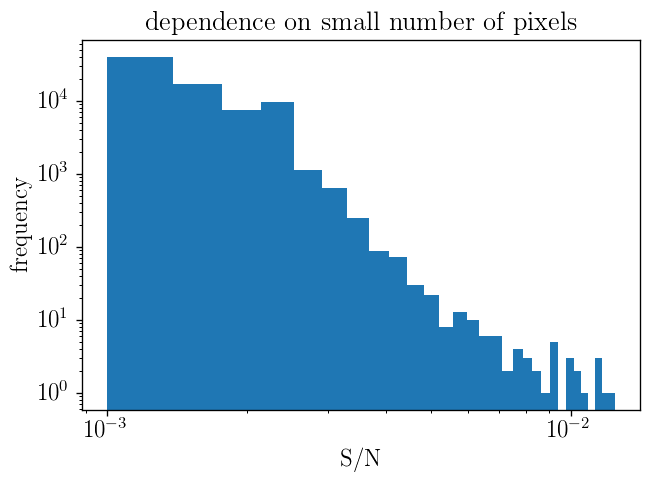

In [59]:
save_fn = f'{prefix}/dependence_pixels.png'
fig, ax = plt.subplots()
ax.hist(SNR_g_s[SNR_g_s>1e-3], bins=30)
ax.set(xscale='log', yscale='log')
ax.set(xlabel='S/N', ylabel='frequency',
       title='dependence on small number of pixels')
plt.savefig(save_fn)
print(f'Plot saved: {save_fn}')
print('Contribution to S/N:')
print('all pixels: ', np.sqrt(np.sum(SNR_g_s**2)))
print('pixels > 1e-2: ', np.sqrt(np.sum(SNR_g_s[SNR_g_s>1e-2]**2)))
print('pixels 1e-3 ~ 1e-2: ', np.sqrt(np.sum(SNR_g_s[np.logical_and(SNR_g_s>1e-3,SNR_g_s<1e-2)]**2)))

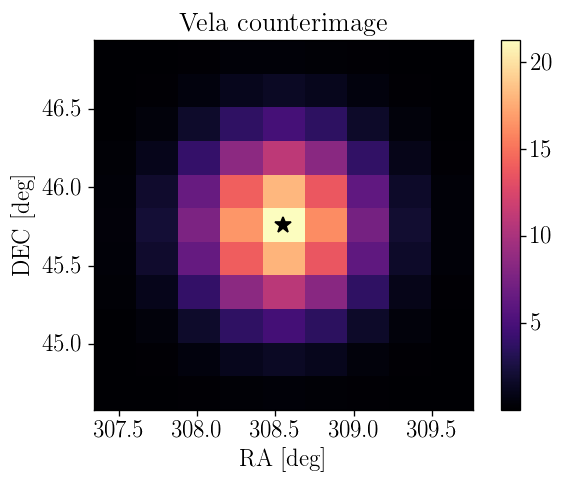

In [56]:
fig, ax = plt.subplots()
im = ax.pcolormesh(np.rad2deg(ra_subgrid), np.rad2deg(dec_subgrid), 1e6 * T_submap, cmap='magma')
ax.plot([np.rad2deg(snr_anti_ra)], [np.rad2deg(snr_anti_dec)], color='k', marker='*', ms=10)
ax.set(title=snr.name() + ' counterimage', xlabel='RA [deg]', ylabel='DEC [deg]', aspect=1)
fig.colorbar(im)

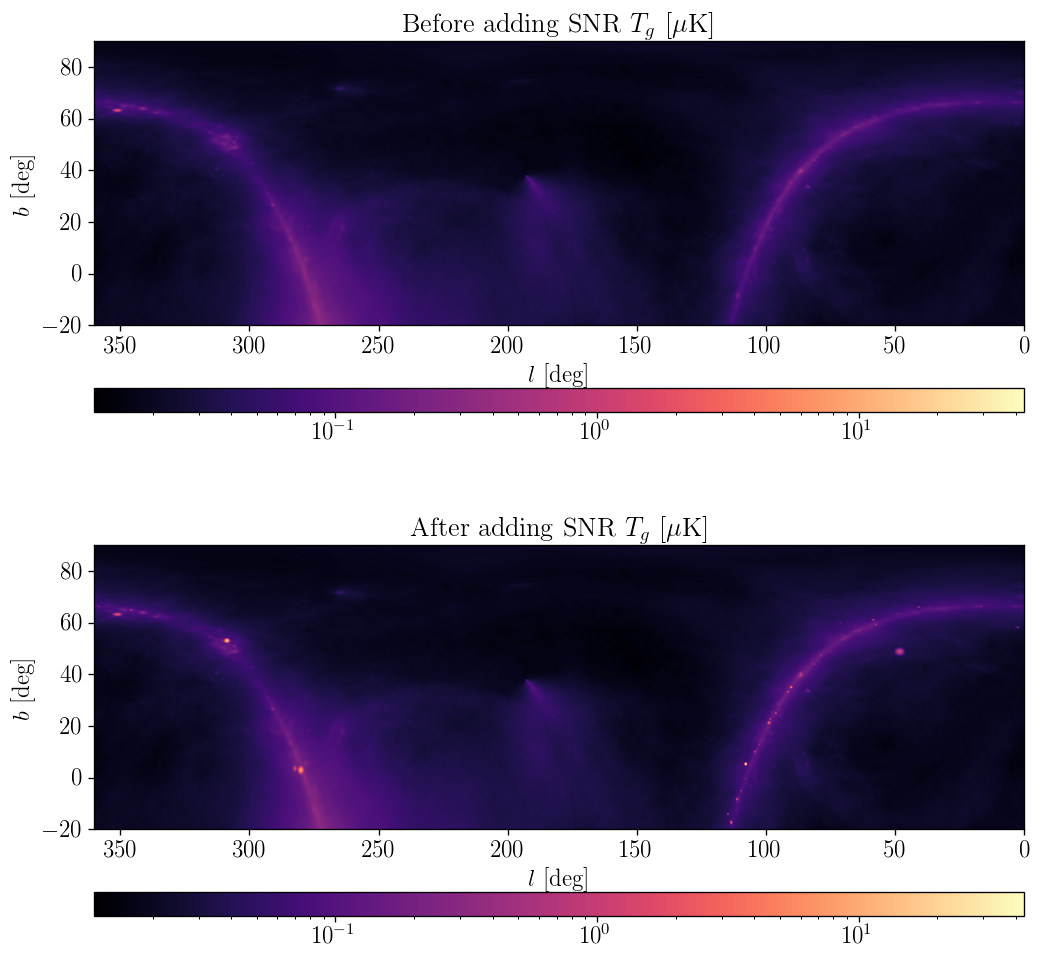

In [69]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

z0 = sig_temp_map * 1e6
z1 = sig_temp_map_snr * 1e6
im0 = axs[0].imshow(np.flip(z0), cmap='magma', extent=CHIME_extent,
                    norm=mpl.colors.LogNorm(np.min(z1), np.max(z1)))
im1 = axs[1].imshow(np.flip(z1), cmap='magma', extent=CHIME_extent,
                    norm=mpl.colors.LogNorm(np.min(z1), np.max(z1)))
axs[0].set(title=r'Before adding SNR $T_g$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(title=r'After adding SNR $T_g$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
fig.colorbar(im0, ax=axs[0], orientation='horizontal', aspect=40)
fig.colorbar(im1, ax=axs[1], orientation='horizontal', aspect=40);